# CMSE 202 Homework 4 (Individual)

## Using SVM and PCA to predict the outcome of chess games

### Goals for this homework assignment

By the end of this assignment, you should be able to:

* Use `git` to track your work and turn in your assignment
* Read and impute data to prepare it for modeling
* Build, fit, and evaluate an SVC model of data
* Use PCA to reduce the number of important features
* Build, fit, and evaluate an SVC model of pca transformed data
* Systematically investigate the effects of the number of components on an SVC model of data


### Assignment instructions:

Work through the following assignment, making sure to follow all of the directions and answer all of the questions.

There are 25 points possible on this assignment. Point values for each part are included in the section headers.

This assignment is due at 11:59 pm on Friday, November 13th. It should be pushed to your repo (See Part 1). 

In [1]:
## Our imports
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA

---
## 1. Adding notebook to your turn-in repository

Like you did for Homework 3, you're going to add it to the CMSE202 repository you created in class so that you can track your progress on the assignment and preserve the final version that you turn in. In order to do this you need to:

* Navigate to your /CMSE202/repos repository and create a new directory called hw-04.
* Move this notebook into that new directory in your repository, then add it and commit it to your repository.
   * Finally, to test that everything is working, "git push" the file so that it ends up in your GitHub repository.

Important: Make sure you've added your TA as a collaborators to your respository with "Read" access so that we can see your assignment. (*If you did this for Homework 3, you do not need to do it again*)

* Section 001: tuethan
* Section 002: Luis-Polanco
* Section 003: DavidRimel

Also important: Make sure that the version of this notebook that you are working on is the same one that you just added to your repository! If you are working on a different copy of the notebook, none of your changes will be tracked.

If everything went as intended, the file should now show up on your GitHub account CMSE202 repository under the hw-04 directory that you just created. Periodically, you'll be asked to commit your changes to the repository and push them to the remote GitHub location. Of course, you can always commit your changes more often than that, if you wish. It can be good to get into a habit of committing your changes any time you make a significant modification, or when you stop working on the project for a bit.

---
## 2. Chess Game Data

The data you will work are configurations of a chess end game. It assumes that a pawn is one move away from ["queening"](https://en.wikipedia.org/wiki/Promotion_(chess)) and 
the other pieces can be moved to perform different offensive or defensive actions. For each of the 36 potential features, there are several potential values for each (entries in a given column). **The details of the data matter a bit less for our purposes, but we are attempting to predict the won/loss by a given side.** If you really want to know about the data, you can look into a [classic text on Artificial Intelligence by Shapiro](https://www.amazon.com/Encyclopedia-Artificial-Intelligence-Stuart-Shapiro/dp/0471807486).

You will first do this with a full model, then investigate how well the model works after a PCA has been done on the data.

### 2.1 Read in the data

First you need to read in the data from `kr-vs-kp.data`. You can look at `kr-vs-kp.names` to see how the data is structured. But we give you the code for the column naming as there are so many features and they are unlabeled in the `.data` file.

```cols = ["bkblk","bknwy","bkon8","bkona","bkspr","bkxbq","bkxcr","bkxwp","blxwp","bxqsq","cntxt","dsopp","dwipd",
 "hdchk","katri","mulch","qxmsq","r2ar8","reskd","reskr","rimmx","rkxwp","rxmsq","simpl","skach","skewr",
 "skrxp","spcop","stlmt","thrsk","wkcti","wkna8","wknck","wkovl","wkpos","wtoeg","won"]```
 
<font size=8 color="#009600">&#9998;</font> Do this - Read in the data from `kr-vs-kp.data` using the columns listed above. Print the `.head()` of the dataframe.

In [2]:
## your code here
cols = ["bkblk","bknwy","bkon8","bkona","bkspr","bkxbq","bkxcr","bkxwp","blxwp","bxqsq","cntxt","dsopp","dwipd",
 "hdchk","katri","mulch","qxmsq","r2ar8","reskd","reskr","rimmx","rkxwp","rxmsq","simpl","skach","skewr",
 "skrxp","spcop","stlmt","thrsk","wkcti","wkna8","wknck","wkovl","wkpos","wtoeg","won"]
data = pd.read_csv("kr-vs-kp.data", names = cols)
data.head(n=10)
# type(data)
# len(data)

,bkblk,bknwy,bkon8,bkona,bkspr,bkxbq,bkxcr,bkxwp,blxwp,bxqsq,...,spcop,stlmt,thrsk,wkcti,wkna8,wknck,wkovl,wkpos,wtoeg,won
0,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
1,f,f,f,f,t,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
2,f,f,f,f,t,f,t,f,f,f,...,f,f,f,f,f,f,t,t,n,won
3,f,f,f,f,f,f,f,f,t,f,...,f,f,f,f,f,f,t,t,n,won
4,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
5,f,f,f,f,f,f,f,f,f,f,...,f,f,t,f,f,f,t,t,n,won
6,f,f,f,f,f,f,f,f,t,f,...,f,f,f,f,f,f,t,t,n,won
7,f,f,f,f,t,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
8,f,f,f,f,f,f,f,f,f,f,...,f,f,f,t,f,f,t,t,n,won
9,f,f,f,f,f,f,t,f,f,f,...,f,f,f,f,f,f,t,t,n,won


### 2.2 Imputing the data

There are no missing data in this data file, but there are some other issues. 

When you print the head of this data set, you probably noticed that all the features and labels are strings. We need to replace them with numerical values for modeling. For the `won` column replace winning with a 1 and losing with a 0. For the other columns, there are seven strings. Replace them using the following table:

| raw data | replaced |
| -------- | -------- |
| f | 1 |
| l | 2 |
| n | 3 |
| t | 4 |
| w | 5 |
| b | 6 |
| g | 7 |

**Note:** this choice really matters and for the models we have learned can really influence the results of our model. We do this because we need to for the model, but we haven't critically thought about the mapping that makes the most sense. There are other models (e.g., [tree-based alogrithms](https://en.wikipedia.org/wiki/Random_forest)) that can handle these categorical data without this mapping.

<font size=8 color="#009600">&#9998;</font> Do this - Replace the entries in the columns as indicated above. Print the `.head()` of the dataframe to show you have succesfull done so.

In [3]:
## your code here

df = data['won'].replace({'won':1, "nowin":0}, inplace=True)

df1 = data.replace(to_replace = {"f": 1, "l": 2, "n": 3, "t": 4, "w": 5, "b": 6, "g": 7})
df1.head()

,bkblk,bknwy,bkon8,bkona,bkspr,bkxbq,bkxcr,bkxwp,blxwp,bxqsq,...,spcop,stlmt,thrsk,wkcti,wkna8,wknck,wkovl,wkpos,wtoeg,won
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,4,4,3,1
1,1,1,1,1,4,1,1,1,1,1,...,1,1,1,1,1,1,4,4,3,1
2,1,1,1,1,4,1,4,1,1,1,...,1,1,1,1,1,1,4,4,3,1
3,1,1,1,1,1,1,1,1,4,1,...,1,1,1,1,1,1,4,4,3,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,4,4,3,1


### 2.3 Separate features and class labels

As we have seen in our analyses using `sklearn` it is advantageous to separate our dataframes into `features` and `labels` for the analysis we are intending to do.

<font size=8 color="#009600">&#9998;</font> Do this - Separate the data frame into two: a features dataframe and a labels dataframe.

In [4]:
## create a features dataframe and a labels dataframe
features = df1.drop(["won"], axis = 1)
labels = df1["won"]

In [5]:
print(sum(labels))
# there are 1669 total ones in our df 
# total is 3196
3196-1669

1669


1527

**Question:** How balanced is your outcome variable? Why does it matter for the outcome to be balanced?

<font size=8 color="#009600">&#9998;</font> Our outcome variable is pretty balanced, there are about 52% of the "ones" (wins) in our dataset and about 48% are zeros (losses). It matters because when we go to train our dataset, our model will look evenly for the numbers of wins and losses becuase both are close to 50%. For example if we had say 80% wins, when we go to train our data our model will look for wins much more than losses resulting in a bias and inaccurate model.

---
## 3. Building an SVC model

For this classification problem, we will use an support vector machine. As you learned in the midterm review, we could easily replace this with any `sklearn` classifier we choose. We will use a linear kernel.

### 3.1 Splitting the data

<font size=8 color="#009600">&#9998;</font> Do this - Split your data into a training and testing set with a train size representing 75% of your data. Print the lengths to show you have the right number of entries.

In [6]:
## your code here

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.25)
print(len(x_test))
print(len(x_train))
# 2397 / 3196 is 75% 
print(labels)

799
2397
0       1
1       1
2       1
3       1
4       1
       ..
3191    0
3192    0
3193    0
3194    0
3195    0
Name: won, Length: 3196, dtype: int64


### 3.2 Modeling the data and evaluting the fit

As you have done this a number of times, we ask you to do most of the analysis in one cell.

<font size=8 color="#009600">&#9998;</font> Do this - Build a linear SVC model (`C=100`), fit it to the training set, use the test features to predict the outcomes. Evaluate the fit using the confusion matrix and classification report.

 **Note:** You should look at the documentation on the confusion matrix because the way `sklearn` outputs false positives and false negatives is different from what most images on the web indicate.

In [7]:
## svc with linear kernel

from sklearn.svm import SVC

svc_linear = SVC(C = 100, kernel = "linear")
svc_linear.fit(x_train, y_train)
pred = svc_linear.predict(x_test)

print("Confusion Matrix: ", confusion_matrix(y_test, pred))
print('Accuracy score: ', accuracy_score(y_test, pred))

Confusion Matrix:  [[401  18]
 [ 13 367]]
Accuracy score:  0.9612015018773467


**Question:** How accurate is your model? What eveidence are you using to determine that? How many false positives and false negatives does it predict?

<font size=8 color="#009600">&#9998;</font> Our model is pretty accurate based on the accuracy score and the confusion matrix that we printed. sklearn outputs the false positives and neagtives different from a usual confusion matrix so based on that knowledge, our model shows that there are 18 false positives and 15 false negatives.

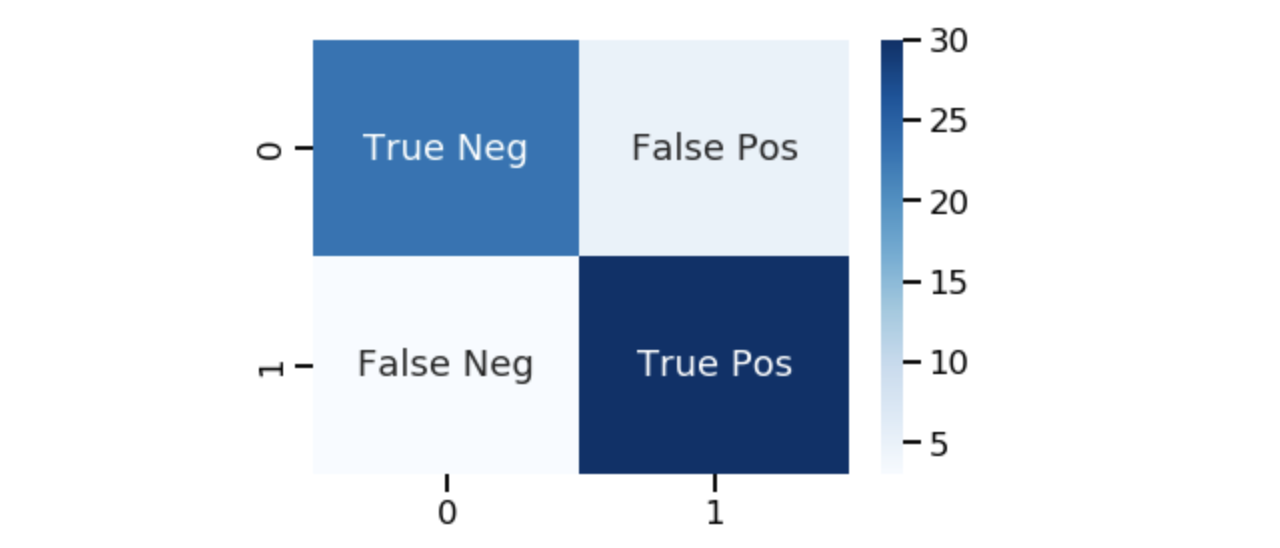

---
## 4. Finding and using the best hyperparameters

We have fit one model and determined it's performance, but is it the best model? We can use `GridSearchCV` to find the best model (given our choices of parameters). Once we do that, we will use that best model going forward. **Note:** you would typically rerun this grid search in a production environment to continue to verify the best model, but we are not for the sake of speed.

### 4.1 Grid search

<font size=8 color="#009600">&#9998;</font> Do this - Using the following parameters (`C` = 1, 10, 100, 1000 and `gamma` = 1e-4, 1e-3, 0.01, 0.1) for both a `linear` and `rbf` kernel use `GridSearchCV` with the `SVC()` model to find the best fit parameters. Print the "best estimators".

In [8]:
## your code here

parameters = {'C': [1, 10, 100, 1000], 'gamma': [1e-4, 1e-3, 0.01, 0.1],
  'kernel': ('rbf', "linear")}

grid = GridSearchCV(SVC(), parameters)
grid.fit(features, labels)

print("the best estimators",grid.best_params_)

/Users/nihalgrewal/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


the best estimators {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


### 4.2 Evaluating the best fit model

Now that we have found the "best estimators", let's determine how good the fit is.

<font size=8 color="#009600">&#9998;</font> Do this - Use the test features to predict the outcomes for the best model. Evaluate the fit using the confusion matrix and classification report. 

**Note:** You should look at the documentation on the confusion matrix because the way `sklearn` outputs false positives and false negatives is different from what most images on the web indicate.

In [9]:
## your code here
g_pred = grid.predict(x_test)


print("Confusion Matrix: ", confusion_matrix(y_test, g_pred))
print('Accuracy score: ', accuracy_score(y_test, g_pred))


Confusion Matrix:  [[418   1]
 [  1 379]]
Accuracy score:  0.9974968710888611


**Question:** How accurate is this best model? What evidence are you using to determine that? How many false positives and false negatives does it predict?

<font size=8 color="#009600">&#9998;</font> The best model is extremely accurate based on our accuracy score and confusion matrix. Our accuracy score shows that the model is nearly flawless with 99% accuracy and the confusion matrix shows that there are only 2 false positives and 0 false negatives.

---
## 5. Using Principal Components

The full model uses 36 features to predict the results. And you likely found that the model is incredibly accurate. But in some cases, we might have even more features (which means much more computational time), and we might not need nearly the level of accuracy we can achieve with the full data set. So, we will see how close we can get with fewer features. But instead of simply removing features, we will use a PCA to determine the featurse that contribute the most the model (through their accounted variance) and use those to build our SVC model.

### 5.1 Building a PCA

We will start with a small number of components (say, 4) to see how well we can predict the outcomes of the games.

<font size=8 color="#009600">&#9998;</font> Do this - Using `PCA()`, fit a pca to your training features with 4 components. Transform both the test and training features using this pca. Plot the `explained_variance_` versus component number.

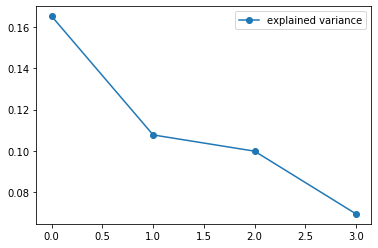

In [10]:
## your code here
n_components = 4 

# print("Extracting the top %d eigenfaces from %d faces" % (n_components, predict_vectors.shape[0]))

pca = PCA(n_components=n_components, whiten=True)

#Fit the training data to the pca model.
pca = pca.fit(x_train)

pca_train_vectors = pca.transform(x_train)
pca_test_vectors = pca.transform(x_test)

# dir(pca)
explained_variance = pca.explained_variance_ratio_ 

plt.plot(explained_variance, label = "explained variance", marker="o")
plt.legend()

**Question:** What is the total explained variance captured by this PCA (we will use this later, just quote the number)? How well do you think a model with this many featuers will perform? Why?

<font size=8 color="#009600">&#9998;</font> The total explained variance captured by this PCA is about 19%. I think a model with this many features would be less accurate becuase it doesn't account for the other numerous features in our original model. Furthermore the explained variance is not that high, showcasing why this specific model needs improvement.

### 5.2 Fit and Evaluate an SVC model

Using the pca transformed features, we will train and test an SVC model using the "best estimators".

<font size=8 color="#009600">&#9998;</font> Do this - Using the pca transformed training data, build and train an SVC model. Predict the classes using the pca transformed test data. Evaluate the model using the classfication report, and the confusion matrix.

In [11]:
## your code here
svc_rbf = SVC(C = 1000, gamma = 0.001, kernel = "rbf")
svc_rbf.fit(pca_train_vectors, y_train)

pred = svc_rbf.predict(pca_test_vectors)

print("Confusion Matrix: ", confusion_matrix(y_test, pred))
print('Accuracy score: ', accuracy_score(y_test, pred))
print("Classification Report:", classification_report(y_test, pred))

Confusion Matrix:  [[247 172]
 [148 232]]
Accuracy score:  0.5994993742177722
Classification Report:               precision    recall  f1-score   support

           0       0.63      0.59      0.61       419
           1       0.57      0.61      0.59       380

    accuracy                           0.60       799
   macro avg       0.60      0.60      0.60       799
weighted avg       0.60      0.60      0.60       799



**Question:** How accurate is this model? What evidence are you using to determine that? How many false positives and false negatives does it predict? How does it compare to the full model?

<font size=8 color="#009600">&#9998;</font> Based on the accuracy score, the model is not that accurate as it is only about 63% correct. Additionally, there are 245 true negatives and 130 false positives as well as 166 false negatives and 258 true positives so based on those values I can determine that the model is less accurate than the full model. Lastly, the classification report states that the model is not that precise and the true postive rate is about 88%.

### 5.3 Repeat your analysis with more components

You probably found that the model with 4 features didn't work so well. What if we increase the number of components (say to 30, which is still 6 fewer than the full data set). What happens now?

<font size=8 color="#009600">&#9998;</font> Do this - Repeat your analysis from 5.1 and 5.2 using 30 components instead.

array([7.28727102, 4.75232723, 4.40541172, 3.06492604, 2.62500748,
       2.40453275, 2.34129551, 1.97714566, 1.77437764, 1.58839328,
       1.290968  , 1.0918046 , 1.02737222, 0.93271603, 0.84130386,
       0.76003138, 0.74451227, 0.66911304, 0.59611566, 0.54616837,
       0.53521367, 0.5062303 , 0.44602327, 0.37868976, 0.31275797,
       0.25916806, 0.23201306, 0.17876194, 0.13912326, 0.10922004])

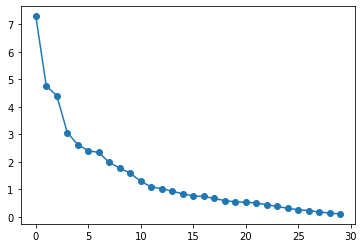

In [12]:
## your code here
n_components = 30

# print("Extracting the top %d eigenfaces from %d faces" % (n_components, predict_vectors.shape[0]))

pca = PCA(n_components=n_components, whiten=True)

#Fit the training data to the pca model.
pca = pca.fit(x_train)

pca_train_vectors = pca.transform(x_train)
pca_test_vectors = pca.transform(x_test)

# dir(pca)

plt.plot(pca.explained_variance_, marker="o")
pca.explained_variance_

In [13]:
svc_rbf = SVC(C = 1000, gamma = 0.001, kernel = "rbf")
svc_rbf.fit(pca_train_vectors, y_train)

pred = svc_rbf.predict(pca_test_vectors)

print("Confusion Matrix: ", confusion_matrix(y_test, pred))
print('Accuracy score: ', accuracy_score(y_test, pred))
print("Classification Report:", classification_report(y_test, pred))

Confusion Matrix:  [[414   5]
 [  6 374]]
Accuracy score:  0.986232790988736
Classification Report:               precision    recall  f1-score   support

           0       0.99      0.99      0.99       419
           1       0.99      0.98      0.99       380

    accuracy                           0.99       799
   macro avg       0.99      0.99      0.99       799
weighted avg       0.99      0.99      0.99       799



**Question:** What is the total explained variance captured by this PCA? How accurate is this model? What evidence are you using to determine that? How many false positives and false negatives does it predict? How does it compare to the 4 component model? To the full model?

<font size=8 color="#009600">&#9998;</font> The total explained variance is about 35%. The model itself is much more accurate as it should be because we evaluated the precision to be 99% and the accuracy score is almost 99%. The model predicts five false positives and only three false negatives, which is very close to the full model prediction of two false positives and one false negative. This model is much more accurate than the four component model because the four component model predicted 134 false positives and 199 false negatives. 

---
## 6. How well does a PCA work?

Clearly, the number of components we use in our PCA matters. Let's investigate how they matter by systematically building a model for any number of selected components.

### 6.1 Accuracy vs. Components

We will do this by writing a function that creates the PCA, the SVC model, fits the training data, predict the labels using test data, and returns the accuracy scores and the explained variance. So your function will take as input:
* the number of components
* the training features
* the test features
* the training labels
* the test labels
and it will return the accuracy scores for an SVC model fit to pca transformed features and the total explained variance.

<font size=8 color="#009600">&#9998;</font> Do this - Create this function, which you will use in the next section.

In [76]:
def p_c_a(n_components, x_train, x_test, y_train, y_test):
#     n_components = 
    pca = PCA(n_components=n_components, whiten=True)
    pca = pca.fit(x_train)
    
    pca_train_vectors = pca.transform(x_train)
    pca_test_vectors = pca.transform(x_test)
    
    
    
    svc_rbf = SVC(C = 1000, gamma = 0.001, kernel = "rbf")
    svc_rbf.fit(pca_train_vectors, y_train)

    pred = svc_rbf.predict(pca_test_vectors)
    return sum(pca.explained_variance_), accuracy_score(y_test, pred)
   

In [77]:
p_c_a(30, x_train, x_test, y_train, y_test)

(43.81799508148608, 0.986232790988736)

### 6.2 Compute accuracies

Now that you have created a function that returns the accuracy for a given number of components, we will use that to plot the how the accuracy of your SVC model changes when we increase the number of components used in the PCA.

<font size=8 color="#009600">&#9998;</font> Do this - For 1 to 36 components, use your function above to compute and store (as a list) the accuracy of your models.

In [78]:
## your code here
comp_a = []
comp_v = []

for n_components in range(1, 37):
    v, a = p_c_a(n_components, x_train, x_test, y_train, y_test)
    comp_a.append(a)
    comp_v.append(v)
#     print(v, a)

### 6.3 Plot accuracy vs number of components

Now that we have those numbers, it makes sense to look at the accuracy vs components.

<font size=8 color="#009600">&#9998;</font> Do this - Plot the accuracy vs components.

Text(0.5, 1.0, 'Accuracy vs. Number of components')

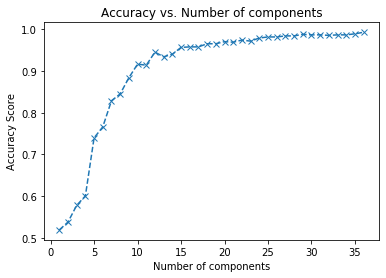

In [79]:
## your code here
plt.plot(np.arange(1, 37, 1), comp_a, "x--")
plt.xlabel("Number of components")
plt.ylabel("Accuracy Score")
plt.title("Accuracy vs. Number of components")
# print(len(comp_a))
# print(len(comp_v))

**Question:** Where does it seem like we have diminishing returns, that is, no major increase in accuracy as we add additional components to the PCA?

<font size=8 color="#009600">&#9998;</font> The point of diminishing returns according to our graph is around the 29/30 component range, as the graph begins to level out around this point and the accuaracy score is >96%

### 6.4 Plot total explained variance vs number of components

<font size=8 color="#009600">&#9998;</font> Do this - Plot the total explained variance vs components. 

Text(0.5, 1.0, 'Explained Variance vs. Number of components')

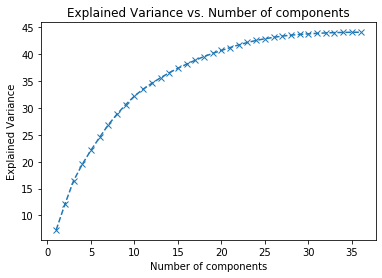

In [80]:
## your code here
plt.plot(np.arange(1, 37, 1), comp_v, "x--")
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs. Number of components")
# print(len(comp_a))
# print(len(comp_v))

**Question:** Where does it seem like we have diminishing returns, that is, no major increase in explained variance as we add additional components to the PCA? How does that number of components compare to the diminishing returns for accuracy?

<font size=8 color="#009600">&#9998;</font> The point of diminishing returns according to our graph is around the 31/32 component range, as the graph begins to level out around this point and the explained variance is greater than about 40%.

---
## 7. Assignment wrap-up¶
Please fill out the form that appears when you run the code below. **You must completely fill this out in order to receive credit for the assignment!**

In [1]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://docs.google.com/forms/d/e/1FAIpQLSc0IBD2mdn4TcRyi-KNXVtS3aEg6U4mOFq2MOciLQyEP4bg1w/viewform?usp=sf_link" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

### Congratulations, you're done!
Submit this assignment by uploading it to the course Desire2Learn web page. Go to the "Homework Assignments" folder, find the dropbox link for Homework 4, and upload your notebook.